In [1]:
# 그래프 데이터 분위수 회귀 적용
# 고려해야 할 문제들

# 1. 그래프 데이터의 특성
# 노드, 엣지, 그래프 전체의 특성이 다름
## 분위수 회귀를 적용할 때, 노드 수준, 엣지 수준, 전체 그래프 수준 중 어디에 적용할 것인지 결정해야 함
# 인접 노드 정보가 필요
## GNN을 통해 각 노드가 주변 이웃 노드들의 정보도 반영한 상태에서 예측해야 함

# 2. 분위수 회귀 적용 문제
# 출력값이 단순한 스칼라 값이 아니라, 분위수별로 여러 개여야 함
# 분위수 간의 불균형성 문제

# 3. 손실함수 정의
# MSE와 달리 분위수 손실은 비대칭적

# GraphSAGE 기반 GNN에서 한 번의 forward pass로 여러 분위수를 동시에 예측
# 입력 벡터에 분위수 정보를 추가하여 각 분위수별 패턴을 명확하게 학습
# 모델이 새로운 분위수를 추가할 때 다시 학습할 필요 없이 일반화 가능
# 훈현 시 다양한 분위수를 랜덤 샘플링하여 학습

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, SGConv
from datasets import load_dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from torch_geometric.transforms import RandomNodeSplit

In [24]:
def augment(x, tau):
    tau = tau.view(-1, 1)
    tau_transformed = (tau - 0.5) * 12  # 분위수 값 변환 (학습 안정성 증가)
    return torch.cat((x, tau_transformed.expand(x.size(0), -1)), dim=1)  # `-tau_transformed` 적용

class GQNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GQNN, self).__init__()
        self.conv1 = SAGEConv(in_channels + 1, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, tau):
        x = augment(x, tau)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x

class QuantileLoss(torch.nn.Module):
    def __init__(self):
        super(QuantileLoss, self).__init__()

    def forward(self, y_pred, y_true, tau):
        diff = y_true - y_pred  # 차이 계산 방식 수정
        loss = torch.where(diff > 0, tau * diff, (1 - tau) * -diff)
        return torch.mean(loss)
    
def train_gqnn(data, device, q="all"):    
    model = GQNN(in_channels=3, hidden_channels=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
    criterion = QuantileLoss()
    data = data.to(device)

    epochs = 1000
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        if q == "all":
            taus = torch.rand(data.x.size(0), 1).to(device)  # Joint Quantile Training
        else:
            taus = torch.full((data.x.size(0), 1), q, device=device)  # Separate Quantile Training

        out = model(data.x, data.edge_index, taus)
        loss = criterion(out, data.y, taus)
        
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
            
    return model

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x
    
def train_gcn(model, data):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
    loss_fn = F.mse_loss
    
    model.train()
    epochs = 1000
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
    
    return model

def cqr_conformal_interval(cal_labels, cal_lower, cal_upper, test_labels, test_lower, test_upper, alpha=0.1):
    """CQR을 활용한 신뢰 구간 계산"""
    cal_scores = np.maximum(cal_labels - cal_upper, cal_lower - cal_labels)
    qhat = np.quantile(cal_scores, np.ceil((len(cal_labels) + 1) * (1 - alpha)) / len(cal_labels), method='higher')
    
    pred_intervals = [test_lower - qhat, test_upper + qhat]
    coverage = ((test_labels >= pred_intervals[0]) & (test_labels <= pred_intervals[1])).mean()
    efficiency = np.mean(test_upper + qhat - (test_lower - qhat))
    
    return pred_intervals, coverage, efficiency

In [15]:
# 그래프 데이터 생성
num_nodes = 1000
num_edges = 2000
node_features = torch.randn(num_nodes, 3)
edges = torch.randint(0, num_nodes, (2, num_edges))
labels = node_features[:, 0].view(-1, 1).mul(5).cos() + 0.3 * torch.randn(num_nodes, 1)

In [16]:
# GQNN 데이터 셋
data = Data(x=node_features, edge_index=edges, y=labels)   

# 데이터 분할 (RandomNodeSplit 사용)
transform = RandomNodeSplit(split="train_rest", num_val=0.0, num_test=0.2)
data = transform(data)

# Train/Test 마스크 생성
train_mask = data.train_mask
test_mask = data.test_mask

# 훈련 및 테스트 데이터 선택
train_data = data.clone()
test_data = data.clone()

train_data.x = data.x[train_mask]
train_data.y = data.y[train_mask]
test_data.x = data.x[test_mask]
test_data.y = data.y[test_mask]

# 노드 인덱스를 매핑하여 edge_index 수정 (훈련 데이터)
train_node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(train_mask.nonzero(as_tuple=True)[0])}
train_edges_mask = train_mask[data.edge_index[0]] & train_mask[data.edge_index[1]]
train_edges = data.edge_index[:, train_edges_mask]

train_data.edge_index = torch.tensor([
    [train_node_mapping[i.item()] for i in train_edges[0]],
    [train_node_mapping[i.item()] for i in train_edges[1]]
], dtype=torch.long)

# 노드 인덱스를 매핑하여 edge_index 수정 (테스트 데이터)
test_node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(test_mask.nonzero(as_tuple=True)[0])}
test_edges_mask = test_mask[data.edge_index[0]] & test_mask[data.edge_index[1]]
test_edges = data.edge_index[:, test_edges_mask]

test_data.edge_index = torch.tensor([
    [test_node_mapping[i.item()] for i in test_edges[0]],
    [test_node_mapping[i.item()] for i in test_edges[1]]
], dtype=torch.long)

# 결과 출력
print(f"Train data: {train_data.x.shape[0]} nodes, {train_data.edge_index.shape[1]} edges")
print(f"Test data: {test_data.x.shape[0]} nodes, {test_data.edge_index.shape[1]} edges")

Train data: 800 nodes, 1325 edges
Test data: 200 nodes, 68 edges


In [17]:
# Joint-separate Training (훈련 데이터만 사용)
device = torch.device("cpu")
train_data = train_data.to(device)
test_data = test_data.to(device)
data = data.to(device)  # 전체 데이터도 디바이스로 이동

net = train_gqnn(train_data, device, 'all')
net_01 = train_gqnn(train_data, device, 0.1)
net_05 = train_gqnn(train_data, device, 0.5)
net_09 = train_gqnn(train_data, device, 0.9)

# 모델 평가 모드 전환
net.eval()
net_01.eval()
net_05.eval()
net_09.eval()

Epoch 0: Loss = 0.4963
Epoch 100: Loss = 0.2187
Epoch 200: Loss = 0.2163
Epoch 300: Loss = 0.2113
Epoch 400: Loss = 0.2098
Epoch 500: Loss = 0.2195
Epoch 600: Loss = 0.2079
Epoch 700: Loss = 0.2080
Epoch 800: Loss = 0.1940
Epoch 900: Loss = 0.1969
Epoch 0: Loss = 0.4956
Epoch 100: Loss = 0.1190
Epoch 200: Loss = 0.1094
Epoch 300: Loss = 0.1058
Epoch 400: Loss = 0.1040
Epoch 500: Loss = 0.1037
Epoch 600: Loss = 0.1003
Epoch 700: Loss = 0.1006
Epoch 800: Loss = 0.0979
Epoch 900: Loss = 0.0960
Epoch 0: Loss = 0.3353
Epoch 100: Loss = 0.2465
Epoch 200: Loss = 0.2181
Epoch 300: Loss = 0.2069
Epoch 400: Loss = 0.1997
Epoch 500: Loss = 0.1899
Epoch 600: Loss = 0.1796
Epoch 700: Loss = 0.1795
Epoch 800: Loss = 0.1715
Epoch 900: Loss = 0.1720
Epoch 0: Loss = 0.3037
Epoch 100: Loss = 0.1184
Epoch 200: Loss = 0.1141
Epoch 300: Loss = 0.1104
Epoch 400: Loss = 0.1073
Epoch 500: Loss = 0.1055
Epoch 600: Loss = 0.1044
Epoch 700: Loss = 0.1051
Epoch 800: Loss = 0.1036
Epoch 900: Loss = 0.1025


GQNN(
  (conv1): SAGEConv(4, 16, aggr=mean)
  (conv2): SAGEConv(16, 16, aggr=mean)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [18]:
# 예측 수행
taus_train = torch.tensor([0.1, 0.5, 0.9], device=device).repeat(train_data.x.size(0), 1)
taus_test = torch.tensor([0.1, 0.5, 0.9], device=device).repeat(test_data.x.size(0), 1)

predictions_train = [
    net(train_data.x, train_data.edge_index, taus_train[:, i:i+1]).detach().cpu().numpy()
    for i in range(3)
]
predictions_test = [
    net(test_data.x, test_data.edge_index, taus_test[:, i:i+1]).detach().cpu().numpy()
    for i in range(3)
]

predictions_train_sep = [
    net_01(train_data.x, train_data.edge_index, taus_train[:, 0:1]).detach().cpu().numpy(),
    net_05(train_data.x, train_data.edge_index, taus_train[:, 1:2]).detach().cpu().numpy(),
    net_09(train_data.x, train_data.edge_index, taus_train[:, 2:3]).detach().cpu().numpy()
]

predictions_test_sep = [
    net_01(test_data.x, test_data.edge_index, taus_test[:, 0:1]).detach().cpu().numpy(),
    net_05(test_data.x, test_data.edge_index, taus_test[:, 1:2]).detach().cpu().numpy(),
    net_09(test_data.x, test_data.edge_index, taus_test[:, 2:3]).detach().cpu().numpy()
]

# 결과 출력
print(f"Train predictions shape (joint): {[p.shape for p in predictions_train]}")
print(f"Test predictions shape (joint): {[p.shape for p in predictions_test]}")
print(f"Train predictions shape (separate): {[p.shape for p in predictions_train_sep]}")
print(f"Test predictions shape (separate): {[p.shape for p in predictions_test_sep]}")

Train predictions shape (joint): [(800, 1), (800, 1), (800, 1)]
Test predictions shape (joint): [(200, 1), (200, 1), (200, 1)]
Train predictions shape (separate): [(800, 1), (800, 1), (800, 1)]
Test predictions shape (separate): [(200, 1), (200, 1), (200, 1)]


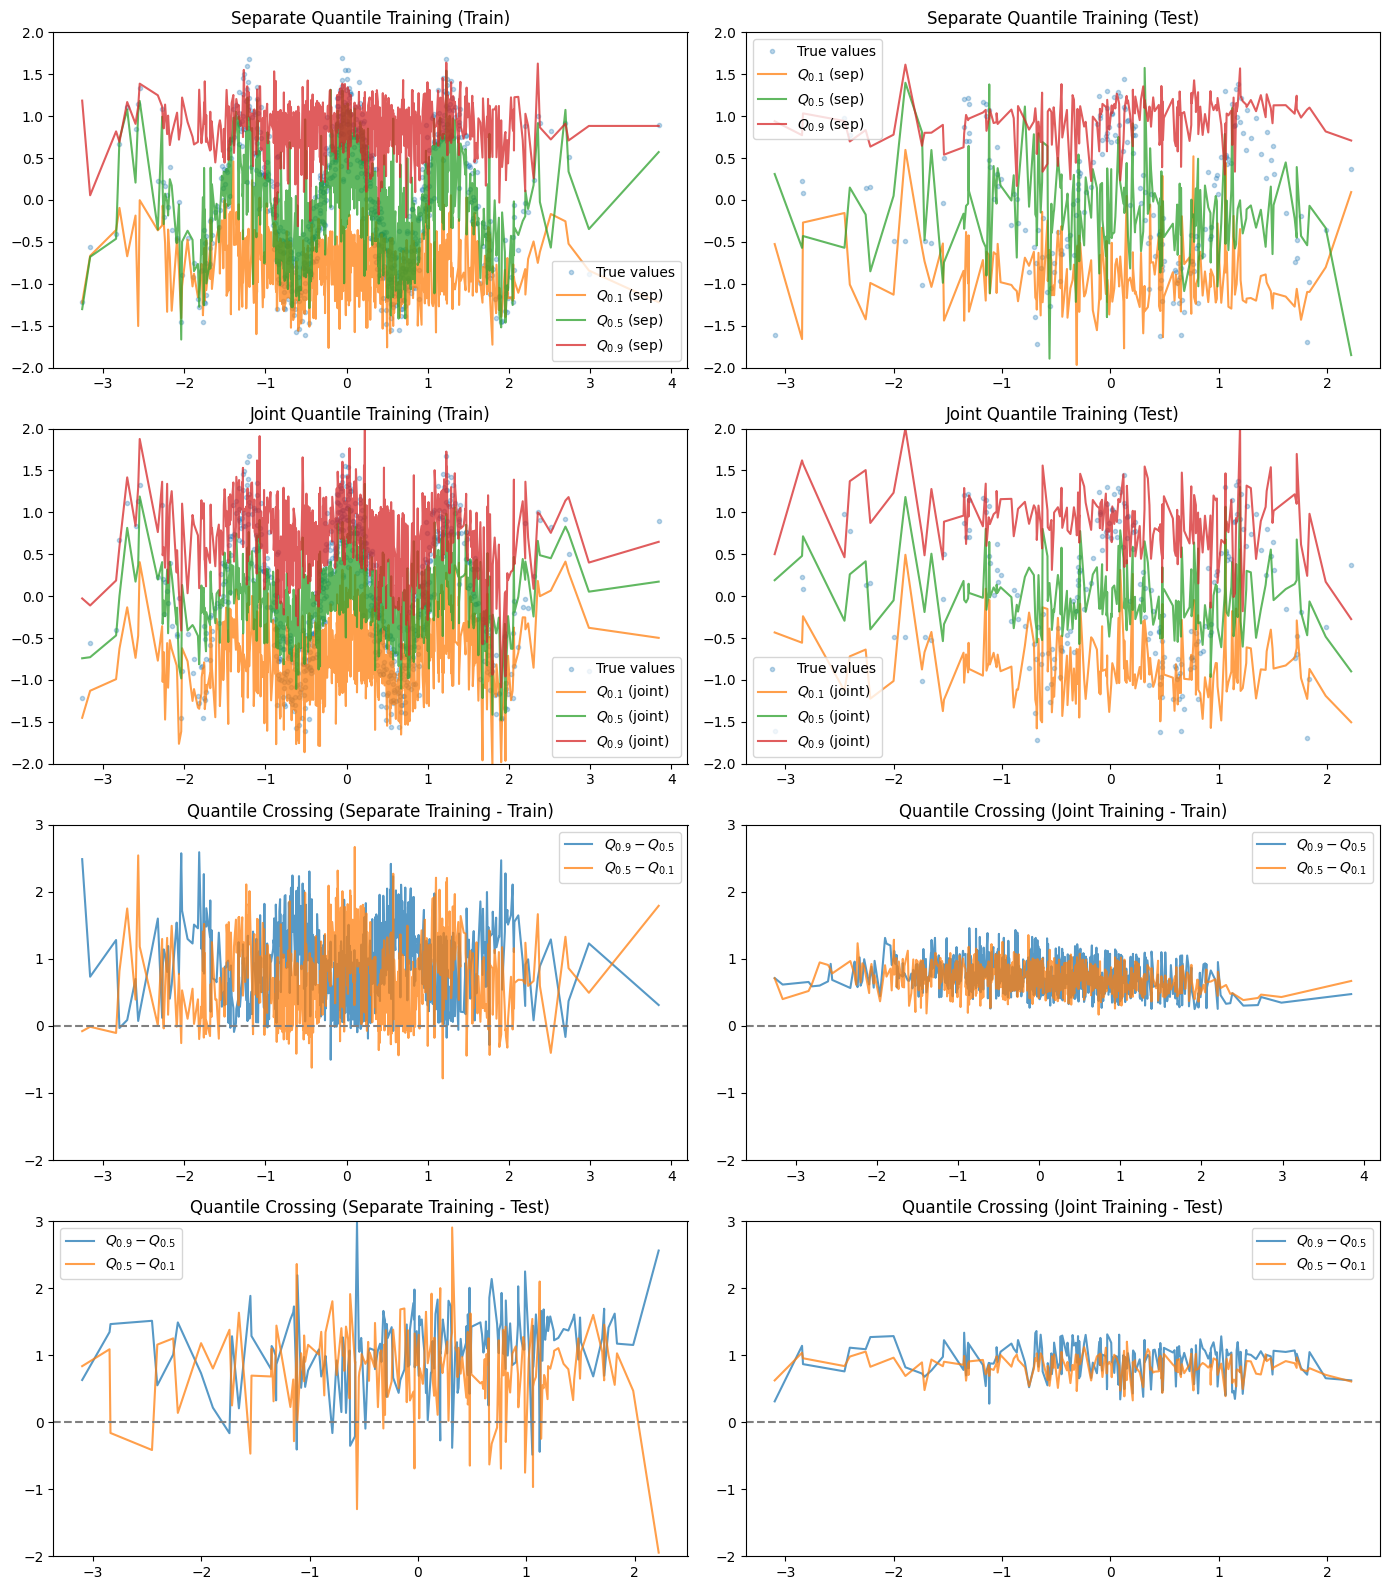

In [8]:
# 데이터 정렬 (훈련 및 테스트 데이터 구분)
sorted_indices_train = torch.sort(train_data.x[:, 0])[1].cpu()
sorted_indices_test = torch.sort(test_data.x[:, 0])[1].cpu()

sorted_x_train = train_data.x[sorted_indices_train, 0].cpu().numpy()
sorted_y_train = train_data.y[sorted_indices_train].cpu().numpy()

sorted_x_test = test_data.x[sorted_indices_test, 0].cpu().numpy()
sorted_y_test = test_data.y[sorted_indices_test].cpu().numpy()

plt.figure(figsize=(14, 16))

# 1️⃣ Separate 학습된 모델의 분위수 교차 확인 (Train)
plt.subplot(4, 2, 1)
plt.title("Separate Quantile Training (Train)")
plt.plot(sorted_x_train, sorted_y_train, '.', alpha=0.3, label="True values")
plt.plot(sorted_x_train, predictions_train_sep[0][sorted_indices_train], alpha=0.75, label="$Q_{0.1}$ (sep)")
plt.plot(sorted_x_train, predictions_train_sep[1][sorted_indices_train], alpha=0.75, label="$Q_{0.5}$ (sep)")
plt.plot(sorted_x_train, predictions_train_sep[2][sorted_indices_train], alpha=0.75, label="$Q_{0.9}$ (sep)")
plt.ylim(-2, 2)
plt.legend()

# 2️⃣ Separate 학습된 모델의 분위수 교차 확인 (Test)
plt.subplot(4, 2, 2)
plt.title("Separate Quantile Training (Test)")
plt.plot(sorted_x_test, sorted_y_test, '.', alpha=0.3, label="True values")
plt.plot(sorted_x_test, predictions_test_sep[0][sorted_indices_test], alpha=0.75, label="$Q_{0.1}$ (sep)")
plt.plot(sorted_x_test, predictions_test_sep[1][sorted_indices_test], alpha=0.75, label="$Q_{0.5}$ (sep)")
plt.plot(sorted_x_test, predictions_test_sep[2][sorted_indices_test], alpha=0.75, label="$Q_{0.9}$ (sep)")
plt.ylim(-2, 2)
plt.legend()

# 3️⃣ Joint 학습된 모델의 분위수 교차 확인 (Train)
plt.subplot(4, 2, 3)
plt.title("Joint Quantile Training (Train)")
plt.plot(sorted_x_train, sorted_y_train, '.', alpha=0.3, label="True values")
plt.plot(sorted_x_train, predictions_train[0][sorted_indices_train], alpha=0.75, label="$Q_{0.1}$ (joint)")
plt.plot(sorted_x_train, predictions_train[1][sorted_indices_train], alpha=0.75, label="$Q_{0.5}$ (joint)")
plt.plot(sorted_x_train, predictions_train[2][sorted_indices_train], alpha=0.75, label="$Q_{0.9}$ (joint)")
plt.ylim(-2, 2)
plt.legend()

# 4️⃣ Joint 학습된 모델의 분위수 교차 확인 (Test)
plt.subplot(4, 2, 4)
plt.title("Joint Quantile Training (Test)")
plt.plot(sorted_x_test, sorted_y_test, '.', alpha=0.3, label="True values")
plt.plot(sorted_x_test, predictions_test[0][sorted_indices_test], alpha=0.75, label="$Q_{0.1}$ (joint)")
plt.plot(sorted_x_test, predictions_test[1][sorted_indices_test], alpha=0.75, label="$Q_{0.5}$ (joint)")
plt.plot(sorted_x_test, predictions_test[2][sorted_indices_test], alpha=0.75, label="$Q_{0.9}$ (joint)")
plt.ylim(-2, 2)
plt.legend()

# 5️⃣ Separate 학습된 모델의 분위수 교차 발생 부분 (Train)
plt.subplot(4, 2, 5)
plt.title("Quantile Crossing (Separate Training - Train)")
plt.plot(sorted_x_train, predictions_train_sep[2][sorted_indices_train] - predictions_train_sep[1][sorted_indices_train], label="$Q_{0.9} - Q_{0.5}$", alpha=0.75)
plt.plot(sorted_x_train, predictions_train_sep[1][sorted_indices_train] - predictions_train_sep[0][sorted_indices_train], label="$Q_{0.5} - Q_{0.1}$", alpha=0.75)
plt.axhline(0, ls="--", color="gray")
plt.ylim(-2, 3)
plt.legend()

# 6️⃣ Joint 학습된 모델의 분위수 교차 발생 부분 (Train)
plt.subplot(4, 2, 6)
plt.title("Quantile Crossing (Joint Training - Train)")
plt.plot(sorted_x_train, predictions_train[2][sorted_indices_train] - predictions_train[1][sorted_indices_train], label="$Q_{0.9} - Q_{0.5}$", alpha=0.75)
plt.plot(sorted_x_train, predictions_train[1][sorted_indices_train] - predictions_train[0][sorted_indices_train], label="$Q_{0.5} - Q_{0.1}$", alpha=0.75)
plt.axhline(0, ls="--", color="gray")
plt.ylim(-2, 3)
plt.legend()

# 7️⃣ Separate 학습된 모델의 분위수 교차 발생 부분 (Test)
plt.subplot(4, 2, 7)
plt.title("Quantile Crossing (Separate Training - Test)")
plt.plot(sorted_x_test, predictions_test_sep[2][sorted_indices_test] - predictions_test_sep[1][sorted_indices_test], label="$Q_{0.9} - Q_{0.5}$", alpha=0.75)
plt.plot(sorted_x_test, predictions_test_sep[1][sorted_indices_test] - predictions_test_sep[0][sorted_indices_test], label="$Q_{0.5} - Q_{0.1}$", alpha=0.75)
plt.axhline(0, ls="--", color="gray")
plt.ylim(-2, 3)
plt.legend()

# 8️⃣ Joint 학습된 모델의 분위수 교차 발생 부분 (Test)
plt.subplot(4, 2, 8)
plt.title("Quantile Crossing (Joint Training - Test)")
plt.plot(sorted_x_test, predictions_test[2][sorted_indices_test] - predictions_test[1][sorted_indices_test], label="$Q_{0.9} - Q_{0.5}$", alpha=0.75)
plt.plot(sorted_x_test, predictions_test[1][sorted_indices_test] - predictions_test[0][sorted_indices_test], label="$Q_{0.5} - Q_{0.1}$", alpha=0.75)
plt.axhline(0, ls="--", color="gray")
plt.ylim(-2, 3)
plt.legend()

plt.tight_layout()
plt.show()


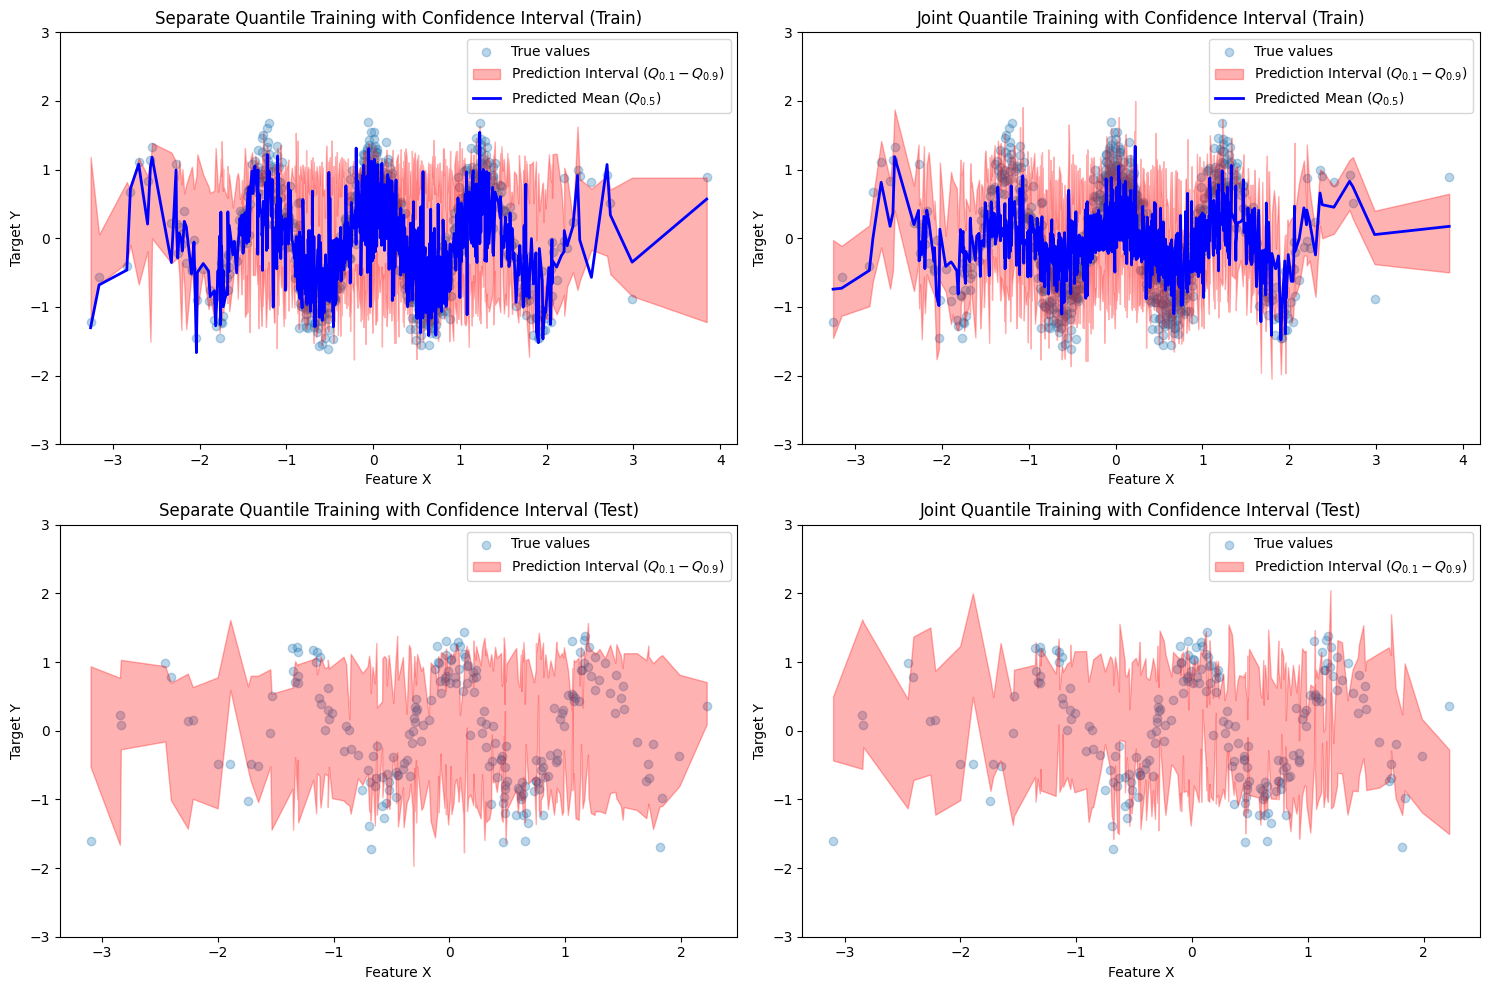

In [10]:
def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.cpu().numpy().squeeze()  # 🔹 차원 축소하여 (N,) 형태로 변환
    return tensor

# 🔹 Train 데이터셋 변환
predictions_train_sep_01 = to_numpy(predictions_train_sep[0])
predictions_train_sep_05 = to_numpy(predictions_train_sep[1])
predictions_train_sep_09 = to_numpy(predictions_train_sep[2])
predictions_train_joint = [to_numpy(p) for p in predictions_train]

sorted_indices_train = torch.sort(train_data.x[:, 0])[1].cpu().numpy()
sorted_x_train = train_data.x[sorted_indices_train, 0].cpu().numpy().squeeze()
sorted_y_train = train_data.y[sorted_indices_train].cpu().numpy().squeeze()

# 🔹 Test 데이터셋 변환
predictions_test_sep_01 = to_numpy(predictions_test_sep[0])
predictions_test_sep_05 = to_numpy(predictions_test_sep[1])
predictions_test_sep_09 = to_numpy(predictions_test_sep[2])
predictions_test_joint = [to_numpy(p) for p in predictions_test]

sorted_indices_test = torch.sort(test_data.x[:, 0])[1].cpu().numpy()
sorted_x_test = test_data.x[sorted_indices_test, 0].cpu().numpy().squeeze()
sorted_y_test = test_data.y[sorted_indices_test].cpu().numpy().squeeze()

plt.figure(figsize=(15, 10))

# 1️⃣ Separate 학습된 모델의 신뢰구간 시각화 (Train)
plt.subplot(2, 2, 1)
plt.title("Separate Quantile Training with Confidence Interval (Train)")
plt.scatter(sorted_x_train, sorted_y_train, alpha=0.3, label="True values")
plt.fill_between(sorted_x_train, 
                 predictions_train_sep_01[sorted_indices_train].squeeze(), 
                 predictions_train_sep_09[sorted_indices_train].squeeze(),
                 color='red', alpha=0.3, label="Prediction Interval ($Q_{0.1} - Q_{0.9}$)")
plt.plot(sorted_x_train, predictions_train_sep_05[sorted_indices_train].squeeze(), 
         color="blue", linewidth=2, label="Predicted Mean ($Q_{0.5}$)")
plt.xlabel("Feature X")
plt.ylabel("Target Y")
plt.ylim(-3, 3)
plt.legend()

# 2️⃣ Separate 학습된 모델의 신뢰구간 시각화 (Test)
plt.subplot(2, 2, 3)
plt.title("Separate Quantile Training with Confidence Interval (Test)")
plt.scatter(sorted_x_test, sorted_y_test, alpha=0.3, label="True values")
plt.fill_between(sorted_x_test, 
                 predictions_test_sep_01[sorted_indices_test].squeeze(), 
                 predictions_test_sep_09[sorted_indices_test].squeeze(),
                 color='red', alpha=0.3, label="Prediction Interval ($Q_{0.1} - Q_{0.9}$)")
# plt.plot(sorted_x_test, predictions_test_sep_05[sorted_indices_test].squeeze(), 
        #  color="blue", linewidth=2, label="Predicted Mean ($Q_{0.5}$)")
plt.xlabel("Feature X")
plt.ylabel("Target Y")
plt.ylim(-3, 3)
plt.legend()

# 3️⃣ Joint 학습된 모델의 신뢰구간 시각화 (Train)
plt.subplot(2, 2, 2)
plt.title("Joint Quantile Training with Confidence Interval (Train)")
plt.scatter(sorted_x_train, sorted_y_train, alpha=0.3, label="True values")
plt.fill_between(sorted_x_train, 
                 predictions_train_joint[0][sorted_indices_train].squeeze(), 
                 predictions_train_joint[2][sorted_indices_train].squeeze(),
                 color='red', alpha=0.3, label="Prediction Interval ($Q_{0.1} - Q_{0.9}$)")
plt.plot(sorted_x_train, predictions_train_joint[1][sorted_indices_train].squeeze(), 
         color="blue", linewidth=2, label="Predicted Mean ($Q_{0.5}$)")
plt.xlabel("Feature X")
plt.ylabel("Target Y")
plt.ylim(-3, 3)
plt.legend()

# 4️⃣ Joint 학습된 모델의 신뢰구간 시각화 (Test)
plt.subplot(2, 2, 4)
plt.title("Joint Quantile Training with Confidence Interval (Test)")
plt.scatter(sorted_x_test, sorted_y_test, alpha=0.3, label="True values")
plt.fill_between(sorted_x_test, 
                 predictions_test_joint[0][sorted_indices_test].squeeze(), 
                 predictions_test_joint[2][sorted_indices_test].squeeze(),
                 color='red', alpha=0.3, label="Prediction Interval ($Q_{0.1} - Q_{0.9}$)")
# plt.plot(sorted_x_test, predictions_test_joint[1][sorted_indices_test].squeeze(), 
        #  color="blue", linewidth=2, label="Predicted Mean ($Q_{0.5}$)")
plt.xlabel("Feature X")
plt.ylabel("Target Y")
plt.ylim(-3, 3)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
## 고정된 분위수 학습 문제
# 현재 모델은 여러 분위수 정보를 포함하여 랜덤 학습하지만, 분위수 값들이 고정되어 있음
# 즉, 특정 데이터 샘플에서 가장 적절한 분위수가 무엇인지 고려되지 않음
# 예를 들어, 데이터가 매우 불균형하거나 특정 노드에서 극단적인 예측이 필요할 경우에도 동일한 분위수로 학습하는 것이 최선은 아닐 수 있음

## 모든 분위수에서 균등한 학습이 보장되지 않음
# 분위수를 랜덤하게 학습하는 방식은 특정 분위수에서 충분한 학습이 이루어지지 않을 수 있음
# 특히 극단적인 분위수는 데이터가 적어 충분히 학습되지 않을 가능성이 높음

## 그래프 구조에 따른 최적 분위수의 차이 반영 부족


## -> 동적 분위수 조정 (Dynamic Quantile Adjustment)
# 각 노드에서 가장 적절한 분위수를 동적으로 선택하여 학습할 수 있음
# 극단적인 분위수에서 충분한 학습이 이루어지도록 조정 가능
# Graph의 구조적 특성을 반영하여 노드별 최적 분위수를 자동으로 조절 가능
# 학습 과정에서 노드별 분위수를 조정하는 매커니즘을 추가

In [28]:
# CP 데이터 셋
data_2 = Data(x=node_features, edge_index=edges, y=labels)

# 데이터 분할 (RandomNodeSplit 사용)
transform = RandomNodeSplit(split="train_rest", num_val=0.2, num_test=0.2)
data_2 = transform(data_2)

# Mask 생성
train_mask = data_2.train_mask
calib_mask = data_2.val_mask  # Calibration을 Validation으로 사용
test_mask = data_2.test_mask

# 훈련, Calibration, 테스트 데이터 복제
train_data = data_2.clone()
calib_data = data_2.clone()
test_data = data_2.clone()

# 각 데이터셋의 노드 특징 및 라벨 설정
train_data.x = data_2.x[train_mask]
train_data.y = data_2.y[train_mask]

calib_data.x = data_2.x[calib_mask]
calib_data.y = data_2.y[calib_mask]

test_data.x = data_2.x[test_mask]
test_data.y = data_2.y[test_mask]

# 노드 인덱스 매핑을 통해 edge_index 수정 (훈련 데이터)
train_node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(train_mask.nonzero(as_tuple=True)[0])}
train_edges_mask = train_mask[data_2.edge_index[0]] & train_mask[data_2.edge_index[1]]
train_edges = data_2.edge_index[:, train_edges_mask]

train_data.edge_index = torch.tensor([
    [train_node_mapping[i.item()] for i in train_edges[0]],
    [train_node_mapping[i.item()] for i in train_edges[1]]
], dtype=torch.long)

# 노드 인덱스 매핑을 통해 edge_index 수정 (Calibration 데이터)
calib_node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(calib_mask.nonzero(as_tuple=True)[0])}
calib_edges_mask = calib_mask[data_2.edge_index[0]] & calib_mask[data_2.edge_index[1]]
calib_edges = data_2.edge_index[:, calib_edges_mask]

calib_data.edge_index = torch.tensor([
    [calib_node_mapping[i.item()] for i in calib_edges[0]],
    [calib_node_mapping[i.item()] for i in calib_edges[1]]
], dtype=torch.long)

# 노드 인덱스 매핑을 통해 edge_index 수정 (테스트 데이터)
test_node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(test_mask.nonzero(as_tuple=True)[0])}
test_edges_mask = test_mask[data_2.edge_index[0]] & test_mask[data_2.edge_index[1]]
test_edges = data.edge_index[:, test_edges_mask]

test_data.edge_index = torch.tensor([
    [test_node_mapping[i.item()] for i in test_edges[0]],
    [test_node_mapping[i.item()] for i in test_edges[1]]
], dtype=torch.long)

# 결과 출력
print(f"Train data: {train_data.x.shape[0]} nodes, {train_data.edge_index.shape[1]} edges")
print(f"Calibration data: {calib_data.x.shape[0]} nodes, {calib_data.edge_index.shape[1]} edges")
print(f"Test data: {test_data.x.shape[0]} nodes, {test_data.edge_index.shape[1]} edges")

Train data: 600 nodes, 734 edges
Calibration data: 200 nodes, 84 edges
Test data: 200 nodes, 85 edges


In [29]:
# 모델 학습 (훈련 데이터만 사용)
device = torch.device("cpu")
model = GCN(in_channels=3, hidden_channels=16, out_channels=3).to(device)
train_data = train_data.to(device)
calib_data = calib_data.to(device)
test_data = test_data.to(device)
model = train_gcn(model, train_data)

# 예측
model.eval()
pred_calib = model(calib_data.x, calib_data.edge_index).detach()
pred_train = model(train_data.x, train_data.edge_index).detach()
pred_test = model(test_data.x, test_data.edge_index).detach()

# GPU에서 CPU로 변환 후 numpy 변환 (필요한 경우)
pred_calib = pred_calib.cpu().numpy() if isinstance(pred_calib, torch.Tensor) else pred_calib
pred_train = pred_train.cpu().numpy() if isinstance(pred_train, torch.Tensor) else pred_train
pred_test = pred_test.cpu().numpy() if isinstance(pred_test, torch.Tensor) else pred_test

# Calibration 데이터에서 신뢰구간의 상한과 하한값 추출
cal_labels = calib_data.y.cpu().numpy().reshape(-1)
cal_upper, cal_lower = pred_calib[:, 2], pred_calib[:, 1]  

# 훈련 데이터 신뢰구간 생성
train_labels = train_data.y.cpu().numpy().reshape(-1)
train_upper, train_lower = pred_train[:, 2], pred_train[:, 1]  

train_pred_intervals, train_coverage, train_efficiency = cqr_conformal_interval(
    cal_labels, cal_lower, cal_upper, train_labels, train_lower, train_upper, alpha=0.1
)

# 테스트 데이터 신뢰구간 생성
test_labels = test_data.y.cpu().numpy().reshape(-1)
test_upper, test_lower = pred_test[:, 2], pred_test[:, 1] 

test_pred_intervals, test_coverage, test_efficiency = cqr_conformal_interval(
    cal_labels, cal_lower, cal_upper, test_labels, test_lower, test_upper, alpha=0.1
)

# 결과 출력
print(f"Train Coverage: {train_coverage:.4f}, Train Efficiency: {train_efficiency:.4f}")
print(f"Test Coverage: {test_coverage:.4f}, Test Efficiency: {test_efficiency:.4f}")


/tmp/ipykernel_442691/2207804288.py:76: UserWarning: Using a target size (torch.Size([600, 1])) that is different to the input size (torch.Size([600, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(out, data.y)


Epoch 0: Loss = 0.6358
Epoch 100: Loss = 0.5664
Epoch 200: Loss = 0.5421
Epoch 300: Loss = 0.5267
Epoch 400: Loss = 0.5216
Epoch 500: Loss = 0.5175
Epoch 600: Loss = 0.5146
Epoch 700: Loss = 0.5137
Epoch 800: Loss = 0.5130
Epoch 900: Loss = 0.5124
Train Coverage: 0.9367, Train Efficiency: 2.5866
Test Coverage: 0.9600, Test Efficiency: 2.5866


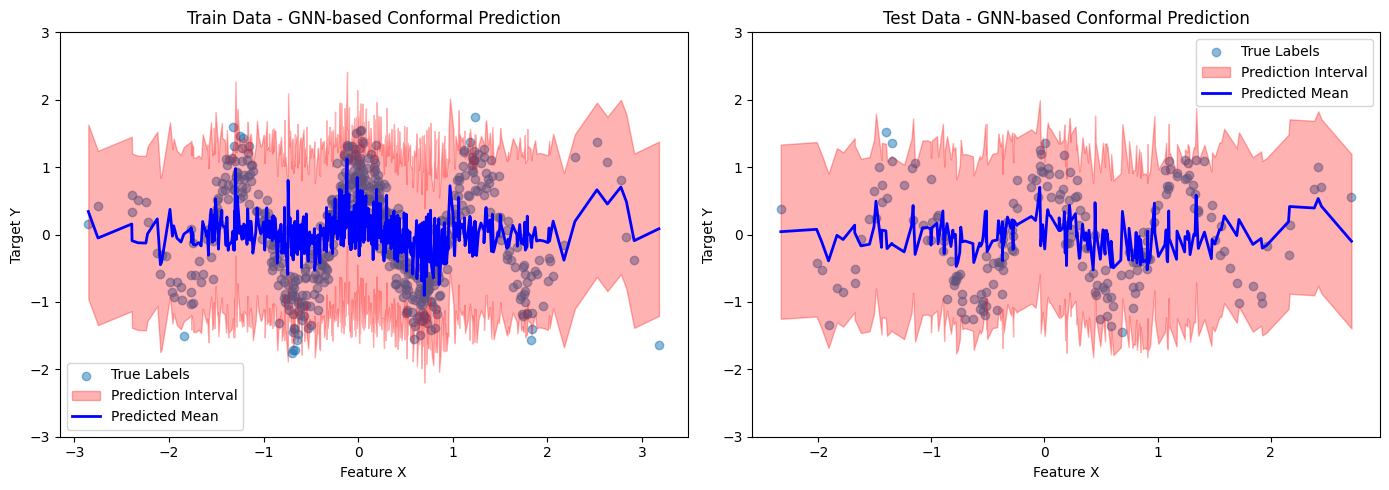

In [30]:
# GPU → CPU 변환 및 NumPy 변환
if isinstance(pred_train, torch.Tensor):
    pred_train = pred_train.cpu().numpy()
if isinstance(pred_test, torch.Tensor):
    pred_test = pred_test.cpu().numpy()

# 🔹 Train 데이터 정렬
sorted_idx_train = np.argsort(train_data.x[:, 0].cpu().numpy())
sorted_x_train = train_data.x[:, 0].cpu().numpy()[sorted_idx_train]
sorted_train_labels = train_labels[sorted_idx_train]
sorted_lower_train = train_pred_intervals[0][sorted_idx_train]
sorted_upper_train = train_pred_intervals[1][sorted_idx_train]
sorted_predictions_train = pred_train[:, 0][sorted_idx_train]  

# 🔹 Test 데이터 정렬
sorted_idx_test = np.argsort(test_data.x[:, 0].cpu().numpy())
sorted_x_test = test_data.x[:, 0].cpu().numpy()[sorted_idx_test]
sorted_test_labels = test_labels[sorted_idx_test]
sorted_lower_test = test_pred_intervals[0][sorted_idx_test]
sorted_upper_test = test_pred_intervals[1][sorted_idx_test]
sorted_predictions_test = pred_test[:, 0][sorted_idx_test] 

# 🔹 Train & Test 데이터 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 🔹 Train 데이터 시각화
axes[0].scatter(sorted_x_train, sorted_train_labels, label="True Labels", alpha=0.5)
axes[0].fill_between(
    sorted_x_train, sorted_lower_train, sorted_upper_train,
    color='red', alpha=0.3, label="Prediction Interval"
)
axes[0].plot(sorted_x_train, sorted_predictions_train, color="blue", linewidth=2, label="Predicted Mean")
axes[0].set_ylim(-3, 3)
axes[0].set_xlabel("Feature X")
axes[0].set_ylabel("Target Y")
axes[0].set_title("Train Data - GNN-based Conformal Prediction")
axes[0].legend()

# 🔹 Test 데이터 시각화
axes[1].scatter(sorted_x_test, sorted_test_labels, label="True Labels", alpha=0.5)
axes[1].fill_between(
    sorted_x_test, sorted_lower_test, sorted_upper_test,
    color='red', alpha=0.3, label="Prediction Interval"
)
axes[1].plot(sorted_x_test, sorted_predictions_test, color="blue", linewidth=2, label="Predicted Mean")
axes[1].set_ylim(-3, 3)
axes[1].set_xlabel("Feature X")
axes[1].set_ylabel("Target Y")
axes[1].set_title("Test Data - GNN-based Conformal Prediction")
axes[1].legend()

plt.tight_layout()
plt.show()